In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras

from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GRU, Dropout, BatchNormalization, SimpleRNN, Bidirectional
#from keras.layers import , LSTM, MaxPooling1D, MaxPool2D, Conv1D, Conv2D, 
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import np_utils

In [3]:
trainpath = '../data/training/'
valpath = '../data/validation/'

mfcc_files = [trainpath + f for f in listdir(trainpath) if 'mfcc.pkl' in f]
target_files = [trainpath + f for f in listdir(trainpath) if 'target.pkl' in f]

mfcc_val = [valpath + f for f in listdir(valpath) if 'mfcc.pkl' in f]
target_val = [valpath + f for f in listdir(valpath) if 'target.pkl' in f]

mfcc_files.sort()
target_files.sort()
mfcc_val.sort()
target_val.sort()

In [4]:
def reload(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [5]:
train_mfcc_reloaded = [reload(f) for f in mfcc_files]
train_target_reloaded = [reload(f) for f in target_files]

val_mfcc_reloaded = [reload(f) for f in mfcc_val]
val_target_reloaded = [reload(f) for f in target_val]

In [6]:
X_train = np.concatenate(train_mfcc_reloaded)
y_train = np.concatenate(train_target_reloaded)
X_val = np.concatenate(val_mfcc_reloaded)
y_val = np.concatenate(val_target_reloaded)

In [7]:
# https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
enocded_y_val = encoder.transform(y_val)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = np_utils.to_categorical(encoded_y_train)
dummy_y_val = np_utils.to_categorical(enocded_y_val)

In [8]:
X_val = X_val.reshape(X_val.shape[0] // 157 // 10, 10, 157)

In [20]:
X_vtrain, X_vtest, y_vtrain, y_vtest = train_test_split(X_val, dummy_y_val, random_state=552)

In [21]:
X = np.concatenate([X_train, X_vtrain])
y = np.concatenate([dummy_y_train, y_vtrain])

In [22]:
X.shape

(84506, 10, 157)

In [23]:
y.shape

(84506, 5)

In [24]:
from tensorflow.keras.optimizers import Adam

In [25]:
model = Sequential()
model.add(BatchNormalization())
model.add(GRU(64, return_sequences=True))
model.add(Dropout(.2))
model.add(Bidirectional(GRU(64, return_sequences=True)))
model.add(Dropout(.2))
model.add(GRU(64))
# model.add(GRU(64, return_sequences=True))
# model.add(GRU(64))
# model.add(GRU(64, return_sequences = True))
# model.add(GRU(64, return_sequences = True))
# model.add(GRU(64))
# model.add(Flatten())
# model.add(Dropout(.2))
# model.add(Dense(128, activation = 'relu'))
# model.add(Dropout(.2))
# model.add(Dense(64, activation = 'relu'))
# model.add(Dropout(.2))
# model.add(Dense(32, activation = 'relu'))
# model.add(Dropout(.2))
model.add(Dense(5, activation = 'softmax'))
model.compile(optimizer = Adam(), loss = 'categorical_crossentropy', metrics = ['acc'])

In [26]:
earlystop = EarlyStopping(patience=5)

In [27]:
history = model.fit(
    x=X,
    y=y,
    validation_data=(X_vtest, y_vtest),
    callbacks=[earlystop],
    epochs=50
)

Epoch 1/50
2641/2641 [==============================] - 46s 16ms/step - loss: 1.4551 - acc: 0.3601 - val_loss: 1.4651 - val_acc: 0.4120
Epoch 2/50
2641/2641 [==============================] - 41s 15ms/step - loss: 1.1077 - acc: 0.5580 - val_loss: 1.3557 - val_acc: 0.4564
Epoch 3/50
2641/2641 [==============================] - 41s 16ms/step - loss: 0.9971 - acc: 0.6082 - val_loss: 1.2912 - val_acc: 0.4870
Epoch 4/50
2641/2641 [==============================] - 40s 15ms/step - loss: 0.9169 - acc: 0.6487 - val_loss: 1.2595 - val_acc: 0.5103
Epoch 5/50
2641/2641 [==============================] - 39s 15ms/step - loss: 0.8684 - acc: 0.6671 - val_loss: 1.2605 - val_acc: 0.5075
Epoch 6/50
2641/2641 [==============================] - 39s 15ms/step - loss: 0.8337 - acc: 0.6816 - val_loss: 1.2007 - val_acc: 0.5385
Epoch 7/50
2641/2641 [==============================] - 39s 15ms/step - loss: 0.8007 - acc: 0.6954 - val_loss: 1.1827 - val_acc: 0.5394
Epoch 8/50
2641/2641 [==========================

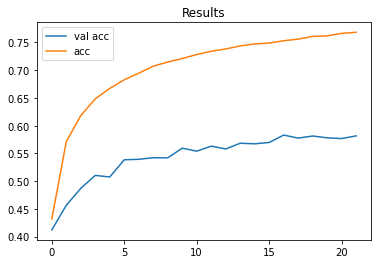

In [28]:
# plot
plt.plot(history.history['val_acc'], label = 'val acc')
plt.plot(history.history['acc'], label = 'acc')
plt.legend()
plt.title('Results');

In [35]:
model.save('../models/gru_random552_030221.h5', save_format='h5')

In [17]:
# reloaded_model = tensorflow.keras.models.load_model('../models/cnn02252021.h5')

In [29]:
y_out = np.apply_along_axis(np.argmax, axis=1, arr=y_vtest)

In [30]:
cm = confusion_matrix(y_out, model.predict_classes(X_vtest))

In [31]:
cm

array([[ 694,  222,  400,  209,  205],
       [ 315,  965,  233,  136,   75],
       [ 340,  138,  966,  213,  156],
       [  99,   70,  103, 1377,   82],
       [ 193,  132,  168,  171, 1085]])

In [36]:
with open('../models/gru_random552_matrix.pkl', 'wb') as f:
    pickle.dump(cm, f)

In [32]:
cm.sum(axis=1, keepdims=True)

array([[1730],
       [1724],
       [1813],
       [1731],
       [1749]])

In [33]:
cm_norm = np.true_divide(cm, cm.sum(axis=1, keepdims=True))

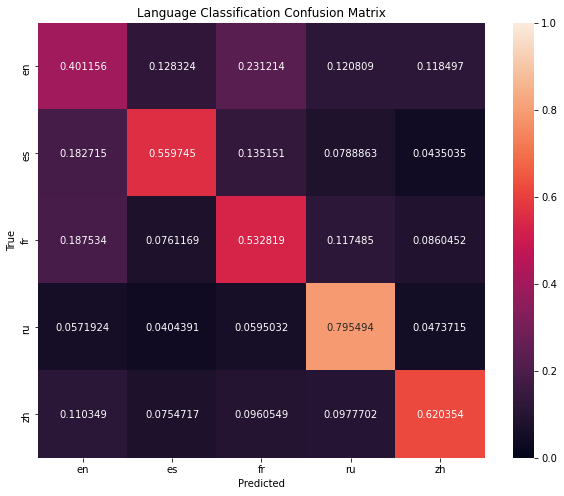

In [34]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, vmin=0, vmax=1, fmt='g', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Language Classification Confusion Matrix")
plt.show()